In [8]:
%pip install --upgrade --quiet tf-nightly-2.0-preview #tf-nightly

Note: you may need to restart the kernel to use updated packages.


In [6]:
import tensorflow as tf
print(tf.__version__)

2.0.0-dev20190629


In [18]:
import pandas as pd
import datetime
print(tf.__version__)
import shutil
import os

# serving inputs to model
inputs = {
    'a' : tf.keras.layers.Input(name='a', shape=(), dtype='int32'),
    'b' : tf.keras.layers.Input(name='b', shape=(), dtype='int32')
}

# feature columns based on training inputs
infc = {
    'a' : tf.feature_column.categorical_column_with_identity('a', num_buckets = 7),
    'b' : tf.feature_column.categorical_column_with_identity('b', num_buckets = 24)
}
#infc['ab'] = tf.feature_column.crossed_column([infc['a'], infc['b']], 2 )

# transformed
outfc = {
    'a' : tf.feature_column.indicator_column(infc['a']),
    'b' : tf.feature_column.indicator_column(infc['b']),
    #'ab': tf.feature_column.embedding_column(infc['ab'], 2)                                            
}

# model architecture
ds = tf.keras.layers.DenseFeatures(outfc.values())(inputs)
output = tf.keras.layers.Dense(1, name='pred')(ds)
model = tf.keras.models.Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

df = pd.DataFrame.from_dict({
    'a': [3, 5, 2],
    'b': [13, 15, 18]
})
y =  [3.0, 2.0, 2.0]

#shutil.rmtree('04_keras/checkpoints/', ignore_errors=True)
#checkpoint_path = "04_keras/checkpoints/nightly.cpt"
#cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                 save_weights_only=True,
#                                                 verbose=1)

model.fit([df['a'], df['b']], y, steps_per_epoch=1) #, callbacks=[cp_callback])
model.evaluate([df['a'], df['b']], y)

model.predict({
    'a': tf.convert_to_tensor([3]),
    'b': tf.convert_to_tensor([13])
})

W0703 15:13:19.802758 139698690950912 training_utils.py:1144] When passing input data as arrays, do not specify `steps_per_epoch`/`steps` argument. Please use `batch_size` instead.


2.0.0-dev20190629
Train on 1 samples
3/3 [==============================] - 0s 22ms/sample - loss: 8.3126 - mse: 8.3126


array([[-0.74923664]], dtype=float32)

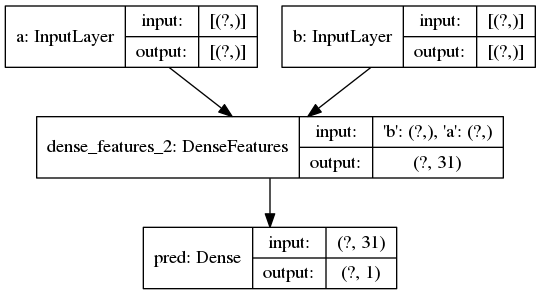

In [19]:
tf.keras.utils.plot_model(model, 'repro_model.png', show_shapes=True)

In [20]:
model.save('04_keras/export/savedmodel')

In [21]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir 04_keras/export/savedmodel

The given SavedModel SignatureDef contains the following input(s):
  inputs['a'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: serving_default_a:0
  inputs['b'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: serving_default_b:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['pred'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [22]:
!find 04_keras/export/savedmodel

04_keras/export/savedmodel
04_keras/export/savedmodel/saved_model.pb
04_keras/export/savedmodel/assets
04_keras/export/savedmodel/variables
04_keras/export/savedmodel/variables/variables.index
04_keras/export/savedmodel/variables/variables.data-00000-of-00001
04_keras/export/savedmodel/variables/checkpoint


In [23]:
# restore from SavedModel
loaded_model = tf.keras.models.load_model('04_keras/export/savedmodel')
loaded_model.predict({
    'a': tf.convert_to_tensor([3]),
    'b': tf.convert_to_tensor([13])
})

ValueError: in converted code:
    relative to /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python:

    keras/saving/saved_model/load.py:239 call
        return call_fn(inputs, *args, **kwargs)
    keras/saving/saved_model/utils.py:46 wrapped_call
        lambda: call_fn(inputs, training=False))
    keras/utils/tf_utils.py:58 smart_cond
        pred, true_fn=true_fn, false_fn=false_fn, name=name)
    framework/smart_cond.py:56 smart_cond
        return false_fn()
    keras/saving/saved_model/utils.py:46 <lambda>
        lambda: call_fn(inputs, training=False))
    eager/def_function.py:417 __call__
        self._initialize(args, kwds, add_initializers_to=initializer_map)
    eager/def_function.py:360 _initialize
        *args, **kwds))
    eager/function.py:1414 _get_concrete_function_internal_garbage_collected
        graph_function, _, _ = self._maybe_define_function(args, kwargs)
    eager/function.py:1718 _maybe_define_function
        graph_function = self._create_graph_function(args, kwargs)
    eager/function.py:1604 _create_graph_function
        capture_by_value=self._capture_by_value),
    framework/func_graph.py:786 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    eager/def_function.py:310 wrapped_fn
        return weak_wrapped_fn().__wrapped__(*args, **kwds)
    saved_model/function_deserialization.py:256 restored_function_body
        "\n\n".join(signature_descriptions)))

    ValueError: Could not find matching function to call loaded from the SavedModel. Got:
      Positional arguments (2 total):
        * [<tf.Tensor 'inputs:0' shape=(None, 1) dtype=int32>, <tf.Tensor 'inputs_1:0' shape=(None, 1) dtype=int32>]
        * False
      Keyword arguments: {}
    
    Expected these arguments to match one of the following 4 option(s):
    
    Option 1:
      Positional arguments (2 total):
        * [TensorSpec(shape=(None,), dtype=tf.int32, name='a'), TensorSpec(shape=(None,), dtype=tf.int32, name='b')]
        * False
      Keyword arguments: {}
    
    Option 2:
      Positional arguments (2 total):
        * [TensorSpec(shape=(None,), dtype=tf.int32, name='a'), TensorSpec(shape=(None,), dtype=tf.int32, name='b')]
        * True
      Keyword arguments: {}
    
    Option 3:
      Positional arguments (2 total):
        * [TensorSpec(shape=(None,), dtype=tf.int32, name='inputs/0'), TensorSpec(shape=(None,), dtype=tf.int32, name='inputs/1')]
        * False
      Keyword arguments: {}
    
    Option 4:
      Positional arguments (2 total):
        * [TensorSpec(shape=(None,), dtype=tf.int32, name='inputs/0'), TensorSpec(shape=(None,), dtype=tf.int32, name='inputs/1')]
        * True
      Keyword arguments: {}


In [8]:
%%writefile repro.json
{"a": "2010-02-08 09:17:00+00:00"}

Overwriting repro.json


In [10]:
!python3 --version

Python 3.5.3


In [59]:
%%bash
MODEL_NAME=repro
VERSION_NAME=v1
if [[ $(gcloud ai-platform models list --format='value(name)' | grep $MODEL_NAME) ]]; then
    echo "$MODEL_NAME already exists"
else
    # create model
    echo "Creating $MODEL_NAME"
    gcloud ai-platform models create --regions=us-central1 $MODEL_NAME
fi

if [[ $(gcloud ai-platform versions list --model $MODEL_NAME --format='value(name)' | grep $VERSION_NAME) ]]; then
    echo "Deleting already existing $MODEL_NAME:$VERSION_NAME ... "
    gcloud ai-platform versions delete --model=$MODEL_NAME $VERSION_NAME
    echo "Please run this cell again if you don't see a Creating message ... "
    sleep 10
fi

# create model
echo "Creating $MODEL_NAME:$VERSION_NAME"
gcloud ai-platform versions create --model=$MODEL_NAME $VERSION_NAME --async \
       --framework=tensorflow --origin=04_keras/export/savedmodel --staging-bucket=gs://cloud-training-demos-ml

repro already exists
Creating repro:v1


In [50]:
!gcloud ai-platform versions list --model repro --format='value(name)'

v1


In [57]:
!gcloud ai-platform predict --model=repro --version=v1 --json-instances=repro.json

ERROR: (gcloud.ai-platform.predict) HTTP request failed. Response: {
  "error": {
    "code": 404,
    "message": "Field: name Error: Online prediction is unavailable for this version. Please verify that CreateVersion has completed successfully.",
    "status": "NOT_FOUND",
    "details": [
      {
        "@type": "type.googleapis.com/google.rpc.BadRequest",
        "fieldViolations": [
          {
            "field": "name",
            "description": "Online prediction is unavailable for this version. Please verify that CreateVersion has completed successfully."
          }
        ]
      }
    ]
  }
}

